In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
import time

In [2]:
# Replace this with your API key
api_key = 'Paste Your API Key Here'

# Initialize Alpha Vantage
ts = TimeSeries(key=api_key, output_format='pandas')

# Fetch 1-minute interval data for a symbol (e.g., AAPL)
data, meta_data = ts.get_intraday(symbol='SPY', interval='1min', outputsize='full')

# Rename and format
data.index = pd.to_datetime(data.index)
data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data.sort_index()

# Save to disk
data.to_csv("SPY_1min.csv")
data.to_pickle("SPY_1min.pkl")

In [3]:
df = pd.read_csv("SPY_1min.csv", index_col=0)
df.index = pd.to_datetime(df.index)
prices = df['Close'].values[-240:]  # Use last 240 minutes of a trading day
volume = df['Volume'].values[-240:]

assert len(prices) == len(volume)


In [4]:
from vwap_execution_env import VWAPExecutionEnv

In [5]:
env = VWAPExecutionEnv(prices=prices, volumes=volume)

obs, _ = env.reset()
qty_each_step = env.total_qty / env.total_steps

rewards = []
for _ in range(len(prices)):
    action = np.array([qty_each_step / env.total_qty])
    obs, reward, done, _, info = env.step(action)
    rewards.append(reward)
    if done:
        break


print(f"TWAP Total Cost: {np.round(-sum(rewards), 2)}")


TWAP Total Cost: 3963779.87


In [6]:
import pandas as pd
import numpy as np

# Load SPY 1-min data
df = pd.read_csv("SPY_1min.csv", index_col=0)
prices = df['Close'].values
volumes = df['Volume'].values

# --- TWAP Execution Environment ---
class VWAPExecutionEnv:
    def __init__(self, prices, volumes, total_qty=10000):
        self.prices = prices
        self.volumes = volumes
        self.total_qty = total_qty
        self.total_steps = len(prices)
        self.current_step = 0
        self.inventory_left = total_qty
        self.executed = []
    
    def reset(self):
        self.current_step = 0
        self.inventory_left = self.total_qty
        self.executed = []
        return self._get_obs(), {}
    
    def _get_obs(self):
        if self.current_step >= len(self.prices):
            return np.array([0.0, 0.0])  # Return dummy observation
        return np.array([self.prices[self.current_step], self.volumes[self.current_step]])

    
    def step(self, action):
        if self.current_step >= len(self.prices):  # Early exit to prevent out-of-bounds
            done = True
            info = {'inventory_left': self.inventory_left}
            return np.array([0.0, 0.0]), 0.0, done, info

        qty = action[0]
        cost = qty * self.prices[self.current_step]
        self.executed.append((qty, self.prices[self.current_step]))
        self.inventory_left -= qty
        self.current_step += 1
        reward = -cost
        done = self.current_step >= len(self.prices) or self.inventory_left <= 0
        info = {'inventory_left': self.inventory_left}
        return self._get_obs(), reward, done, info



# Initialize environment
env = VWAPExecutionEnv(prices=prices, volumes=volumes)
obs, _ = env.reset()

# --- TWAP Execution ---
qty_each_step = env.total_qty / min(env.total_steps, len(prices))  # prevent overflow
total_cost = 0
rewards = []

for t in range(env.total_steps):
    action = np.array([qty_each_step])
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    if done:
        break

# --- Summary ---
final_inventory = info['inventory_left']
total_cost = -sum(rewards)  # Convert negative reward to cost
print(f"✅ TWAP Total Cost: {total_cost:,.2f}")
print(f"✅ Final Inventory Left: {final_inventory:.2f}")
print(f"✅ Total Qty Executed: {env.total_qty - final_inventory:.2f}")
print(f"✅ Episode Length: {env.current_step}")


✅ TWAP Total Cost: 6,285,840.98
✅ Final Inventory Left: -0.00
✅ Total Qty Executed: 10000.00
✅ Episode Length: 21097


### Set up the Gymnasium-based environment for the PPO agent

In [7]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class VWAPExecutionEnv(gym.Env):
    def __init__(self, prices, volumes, total_qty=10000, total_steps=None):
        super(VWAPExecutionEnv, self).__init__()
        self.executed = []
        self.prices = np.array(prices)
        self.volumes = np.array(volumes)
        self.total_inventory = total_qty  # Alias for consistency
        self.total_qty = total_qty
        self.total_steps = total_steps or len(prices)
        self.action_space = gym.spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(4,), dtype=np.float32  # [price, volume, inventory %, time %]
        )

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Optional: for reproducibility if you're using gym.Env
        self.current_step = 0
        self.executed = []
        self.inventory_left = self.total_qty
        obs = self._get_obs()
        return obs, {}

    def step(self, action):
        print(f"[Step {self.current_step}] Action: {action[0]:.4f}, Inventory Left: {self.inventory_left:.2f}")
        qty = float(action[0]) * (self.inventory_left)  # adaptively scale remaining inventory
        qty = min(qty, self.inventory_left)

        price = self.prices[self.current_step]
        cost = qty * price
        print(f"[Step {self.current_step}] Action: {action[0]:.4f}, Inventory Left: {self.inventory_left:.2f}, Qty: {qty:.2f}")
        self.executed.append((qty, price))
        
        self.inventory_left -= qty
        self.current_step += 1

        volume = self.volumes[self.current_step]
        cost_penalty = cost / 1e4
        impact_penalty = (qty / volume) * 0.5  # 0.5 is weight, tuneable
        time_penalty = (self.inventory_left / (self.total_steps - self.current_step + 1)) * 0.1

        reward = -(cost_penalty + impact_penalty + time_penalty)

        done = self.current_step >= self.total_steps or self.inventory_left <= 0

        # Final inventory penalty at end of episode
        if done and self.inventory_left > 0:
            leftover_penalty = self.inventory_left * price
            reward -= leftover_penalty / 1e4

        obs = self._get_obs()
        info = {'inventory_left': self.inventory_left}
        terminated = done  # now correctly returning bool for stable-baselines3
        truncated = False  # we don’t use early truncation here

        return obs, reward, terminated, truncated, info

    def _get_obs(self):
        normalized_price = self.prices[self.current_step] / 1e4
        normalized_volume = self.volumes[self.current_step] / max(self.volumes)
        inventory_ratio = self.inventory_left / self.total_qty
        time_ratio = self.current_step / self.total_steps
        return np.array([normalized_price, normalized_volume, inventory_ratio, time_ratio], dtype=np.float32)








In [8]:
env = VWAPExecutionEnv(prices=prices, volumes=volumes)
obs = env.reset()


In [9]:
import pandas as pd

# Load SPY 1-minute data from the uploaded file
df = pd.read_csv("SPY_1min.csv", index_col=0)
prices = df['Close'].values
volumes = df['Volume'].values

# Prepare environment
from gymnasium.wrappers import NormalizeObservation
env = VWAPExecutionEnv(prices=prices, volumes=volumes)
env = NormalizeObservation(env)

# Confirm environment reset
obs = env.reset()
obs[:5]  # Display first few observation values to verify setup


(array([6.2166457e-04, 2.4354013e-05, 7.0725949e-03, 0.0000000e+00],
       dtype=float32),
 {})

## Train PPO Agent

In [10]:
# !pip install stable-baselines3


In [11]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap your env for SB3 compatibility
dummy_env = DummyVecEnv([lambda: env])

# Optional: Check environment conforms to Gym standards
check_env(env, warn=True)

# Initialize PPO model
model = PPO("MlpPolicy", dummy_env, verbose=1)

# Train PPO agent
model.learn(total_timesteps=50000)

# Save model
model.save("ppo_vwap_agent")


/opt/anaconda3/envs/opex/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:462: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


[Step 0] Action: 0.4929, Inventory Left: 10000.00
[Step 0] Action: 0.4929, Inventory Left: 10000.00, Qty: 4929.14
[Step 0] Action: 0.6039, Inventory Left: 10000.00
[Step 0] Action: 0.6039, Inventory Left: 10000.00, Qty: 6038.81
[Step 1] Action: 0.2893, Inventory Left: 3961.19
[Step 1] Action: 0.2893, Inventory Left: 3961.19, Qty: 1145.79
[Step 2] Action: 0.6308, Inventory Left: 2815.40
[Step 2] Action: 0.6308, Inventory Left: 2815.40, Qty: 1776.04
[Step 3] Action: 0.3586, Inventory Left: 1039.36
[Step 3] Action: 0.3586, Inventory Left: 1039.36, Qty: 372.75
[Step 4] Action: 0.7466, Inventory Left: 666.61
[Step 4] Action: 0.7466, Inventory Left: 666.61, Qty: 497.70
[Step 5] Action: 0.2478, Inventory Left: 168.91
[Step 5] Action: 0.2478, Inventory Left: 168.91, Qty: 41.86
[Step 6] Action: 0.3543, Inventory Left: 127.05
[Step 6] Action: 0.3543, Inventory Left: 127.05, Qty: 45.02
[Step 7] Action: 0.3459, Inventory Left: 82.04
[Step 7] Action: 0.3459, Inventory Left: 82.04, Qty: 28.38
[Step 

In [12]:
# Unwrap to base environment
base_env = env
while hasattr(base_env, 'env'):
    base_env = base_env.env

# Evaluate PPO Agent
obs = env.reset()[0]
done = False
total_reward = 0

while not done:
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    done = terminated or truncated

# Print results
print(f"\n📊 PPO Agent Final Inventory Left: {info['inventory_left']:.2f}")
print(f"📈 PPO Agent Total Qty Executed: {base_env.total_qty - info['inventory_left']:.2f}")
print(f"💰 PPO Agent Total Cost (Reward): {-total_reward:.2f}")


[Step 0] Action: 0.0000, Inventory Left: 10000.00
[Step 0] Action: 0.0000, Inventory Left: 10000.00, Qty: 0.00
[Step 1] Action: 0.0000, Inventory Left: 10000.00
[Step 1] Action: 0.0000, Inventory Left: 10000.00, Qty: 0.00
[Step 2] Action: 0.0000, Inventory Left: 10000.00
[Step 2] Action: 0.0000, Inventory Left: 10000.00, Qty: 0.00
[Step 3] Action: 0.0000, Inventory Left: 10000.00
[Step 3] Action: 0.0000, Inventory Left: 10000.00, Qty: 0.00
[Step 4] Action: 0.0000, Inventory Left: 10000.00
[Step 4] Action: 0.0000, Inventory Left: 10000.00, Qty: 0.00
[Step 5] Action: 0.0000, Inventory Left: 10000.00
[Step 5] Action: 0.0000, Inventory Left: 10000.00, Qty: 0.00
[Step 6] Action: 0.0000, Inventory Left: 10000.00
[Step 6] Action: 0.0000, Inventory Left: 10000.00, Qty: 0.00
[Step 7] Action: 0.0000, Inventory Left: 10000.00
[Step 7] Action: 0.0000, Inventory Left: 10000.00, Qty: 0.00
[Step 8] Action: 0.0000, Inventory Left: 10000.00
[Step 8] Action: 0.0000, Inventory Left: 10000.00, Qty: 0.00
[

### Plotting

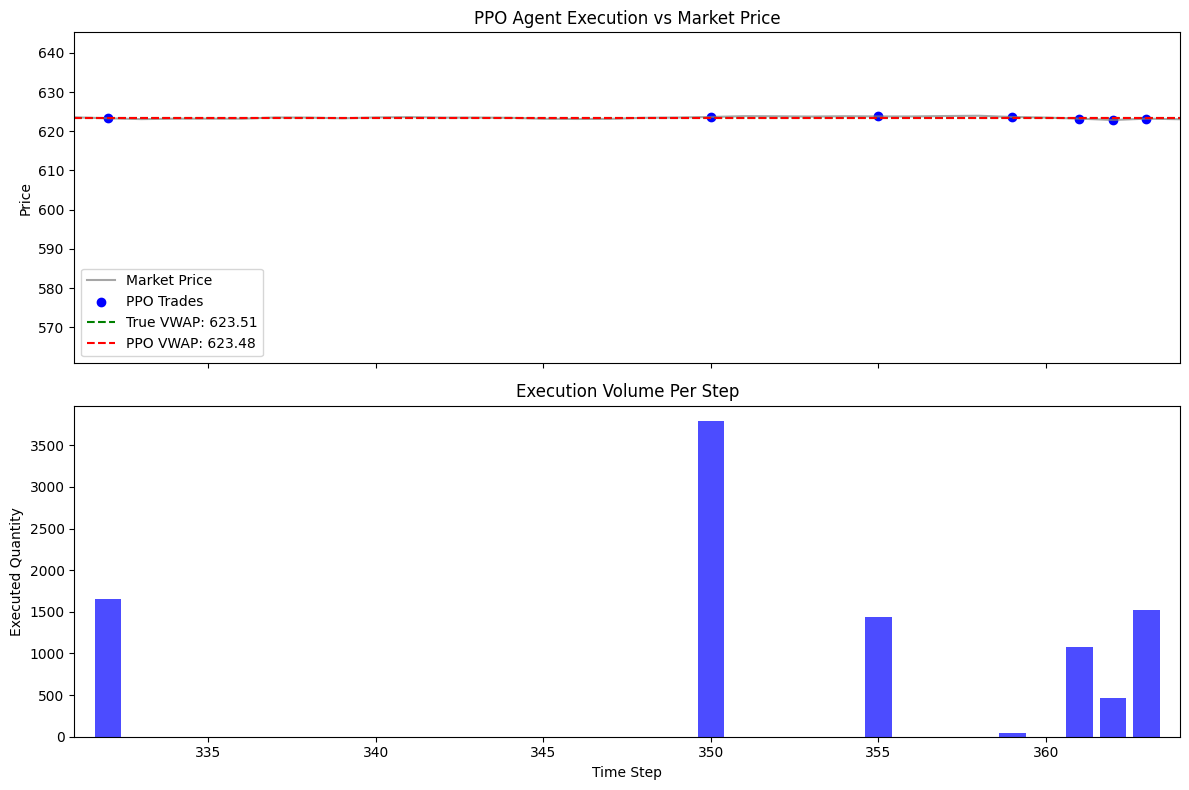

In [13]:
# Assume PPO agent has been trained and environment has been evaluated
# At this point, env = NormalizeObservation(env) and you have run a full episode with the PPO agent

import matplotlib.pyplot as plt
import numpy as np

# 👉 Unwrap original custom environment
env_unwrapped = env.env

# ✅ Extract data from the unwrapped env
executed = np.array(env_unwrapped.executed)
qtys, prices = executed[:, 0], executed[:, 1]
steps = np.arange(len(qtys))

# VWAP calculations
market_prices = env_unwrapped.prices
market_volumes = env_unwrapped.volumes

true_vwap = np.sum(market_prices[:len(qtys)] * market_volumes[:len(qtys)]) / np.sum(market_volumes[:len(qtys)])
ppo_vwap = np.sum(qtys * prices) / np.sum(qtys)

nonzero_mask = qtys > 0

# 📊 Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(market_prices, label='Market Price', color='gray', alpha=0.7)
axs[0].scatter(steps[nonzero_mask], prices[nonzero_mask], label='PPO Trades', color='blue')
axs[0].axhline(true_vwap, linestyle='--', color='green', label=f"True VWAP: {true_vwap:.2f}")
axs[0].axhline(ppo_vwap, linestyle='--', color='red', label=f"PPO VWAP: {ppo_vwap:.2f}")
axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].set_title("PPO Agent Execution vs Market Price")


axs[1].bar(steps[nonzero_mask], qtys[nonzero_mask], color='blue', alpha=0.7)
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Executed Quantity")
axs[1].set_title("Execution Volume Per Step")

axs[0].set_xlim([steps[nonzero_mask][0] - 1, steps[nonzero_mask][-1] + 1])
axs[1].set_xlim([steps[nonzero_mask][0] - 1, steps[nonzero_mask][-1] + 1])


plt.tight_layout()
plt.show()


In [14]:
# Optional: write to CSV
np.savetxt("ppo_executions.csv", executed, delimiter=",", header="qty,price", comments='')


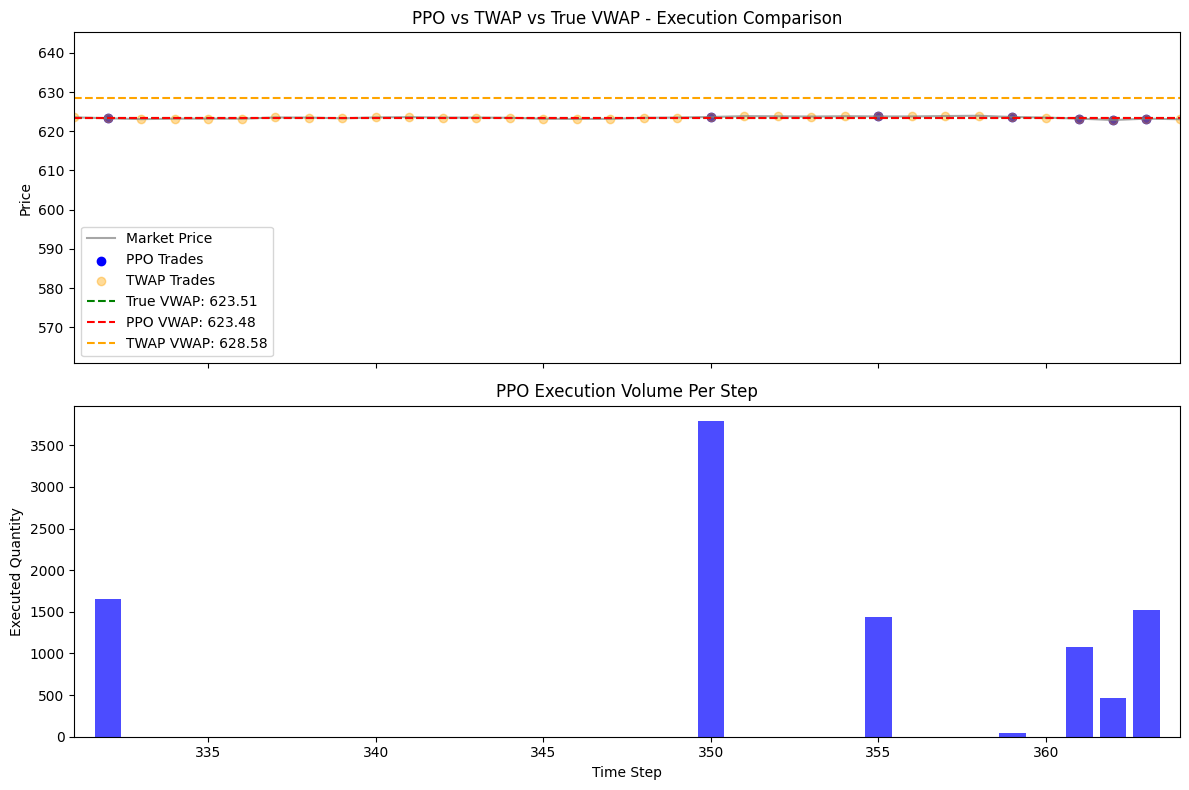

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# ─────────────────────────────────────────────
# ✅ 1. Unwrap the environment and extract PPO executions
env_unwrapped = env.env  # env = NormalizeObservation(env), unwrap to access custom attributes

executed = np.array(env_unwrapped.executed)
qtys, prices = executed[:, 0], executed[:, 1]
steps = np.arange(len(qtys))

market_prices = env_unwrapped.prices
market_volumes = env_unwrapped.volumes

# ─────────────────────────────────────────────
# ✅ 2. VWAP Calculations
true_vwap = np.sum(market_prices[:len(qtys)] * market_volumes[:len(qtys)]) / np.sum(market_volumes[:len(qtys)])
ppo_vwap = np.sum(qtys * prices) / np.sum(qtys)

nonzero_mask = qtys > 0

# ─────────────────────────────────────────────
# ✅ 3. TWAP Benchmark Execution
total_inventory = env_unwrapped.total_qty
total_steps = env_unwrapped.total_steps

twap_qty_per_step = total_inventory / total_steps
twap_executed = []

for t in range(total_steps):
    price = market_prices[t]
    qty = twap_qty_per_step
    twap_executed.append((qty, price))

twap_executed = np.array(twap_executed)
twap_qtys = twap_executed[:, 0]
twap_prices = twap_executed[:, 1]
twap_vwap = np.sum(twap_qtys * twap_prices) / np.sum(twap_qtys)

# ─────────────────────────────────────────────
# ✅ 4. Plotting Everything

fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Price Plot
axs[0].plot(market_prices, label='Market Price', color='gray', alpha=0.7)
axs[0].scatter(steps[nonzero_mask], prices[nonzero_mask], label='PPO Trades', color='blue')
axs[0].scatter(np.arange(total_steps), twap_prices, color='orange', alpha=0.4, label='TWAP Trades')

axs[0].axhline(true_vwap, linestyle='--', color='green', label=f"True VWAP: {true_vwap:.2f}")
axs[0].axhline(ppo_vwap, linestyle='--', color='red', label=f"PPO VWAP: {ppo_vwap:.2f}")
axs[0].axhline(twap_vwap, linestyle='--', color='orange', label=f"TWAP VWAP: {twap_vwap:.2f}")

axs[0].set_ylabel('Price')
axs[0].legend()
axs[0].set_title("PPO vs TWAP vs True VWAP - Execution Comparison")

# Quantity Plot
axs[1].bar(steps[nonzero_mask], qtys[nonzero_mask], color='blue', alpha=0.7)
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Executed Quantity")
axs[1].set_title("PPO Execution Volume Per Step")

# Set same x-limits for zoomed clarity
axs[0].set_xlim([steps[nonzero_mask][0] - 1, steps[nonzero_mask][-1] + 1])
axs[1].set_xlim([steps[nonzero_mask][0] - 1, steps[nonzero_mask][-1] + 1])

plt.tight_layout()
plt.show()


In [16]:
# --- Performance Metrics ---
total_qty = np.sum(qtys)

# 1. Cost Saving over TWAP
cost_saving_pct = ((twap_vwap - ppo_vwap) / twap_vwap) * 100

# 2. Implementation Shortfall (vs. True VWAP)
implementation_shortfall = (ppo_vwap - true_vwap) * total_qty

# 3. Slippage: PPO execution price - market price at execution time
slippage = prices[nonzero_mask] - market_prices[steps[nonzero_mask]]
mean_slippage = np.mean(slippage)
std_slippage = np.std(slippage)

# 4. Execution Efficiency Score
execution_efficiency = (twap_vwap - ppo_vwap) / std_slippage if std_slippage != 0 else np.nan

# --- Print Summary ---
print("\n🔍 Execution Performance Summary")
print(f"✅ PPO VWAP       : {ppo_vwap:.2f}")
print(f"📊 TWAP VWAP      : {twap_vwap:.2f}")
print(f"📈 True VWAP      : {true_vwap:.2f}")
print(f"💰 Total Quantity : {total_qty:.2f}")
print(f"📉 Cost Saving    : {cost_saving_pct:.2f}% over TWAP")
print(f"📉 Implementation Shortfall (vs. True VWAP): {implementation_shortfall:.2f}")
print(f"📏 Mean Slippage  : {mean_slippage:.4f}")
print(f"📐 Std Slippage   : {std_slippage:.4f}")
print(f"📊 Efficiency Score: {execution_efficiency:.2f}")



🔍 Execution Performance Summary
✅ PPO VWAP       : 623.48
📊 TWAP VWAP      : 628.58
📈 True VWAP      : 623.51
💰 Total Quantity : 10000.00
📉 Cost Saving    : 0.81% over TWAP
📉 Implementation Shortfall (vs. True VWAP): -284.44
📏 Mean Slippage  : 0.0000
📐 Std Slippage   : 0.0000
📊 Efficiency Score: nan


In [17]:
print(f"Execution prices: {prices[nonzero_mask]}")
print(f"Market prices   : {market_prices[steps[nonzero_mask]]}")
print(f"Slippage        : {slippage}")


Execution prices: [623.33   623.66   623.8    623.6526 623.235  622.8808 623.23  ]
Market prices   : [623.33   623.66   623.8    623.6526 623.235  622.8808 623.23  ]
Slippage        : [0. 0. 0. 0. 0. 0. 0.]


### Cost Comparison Plot

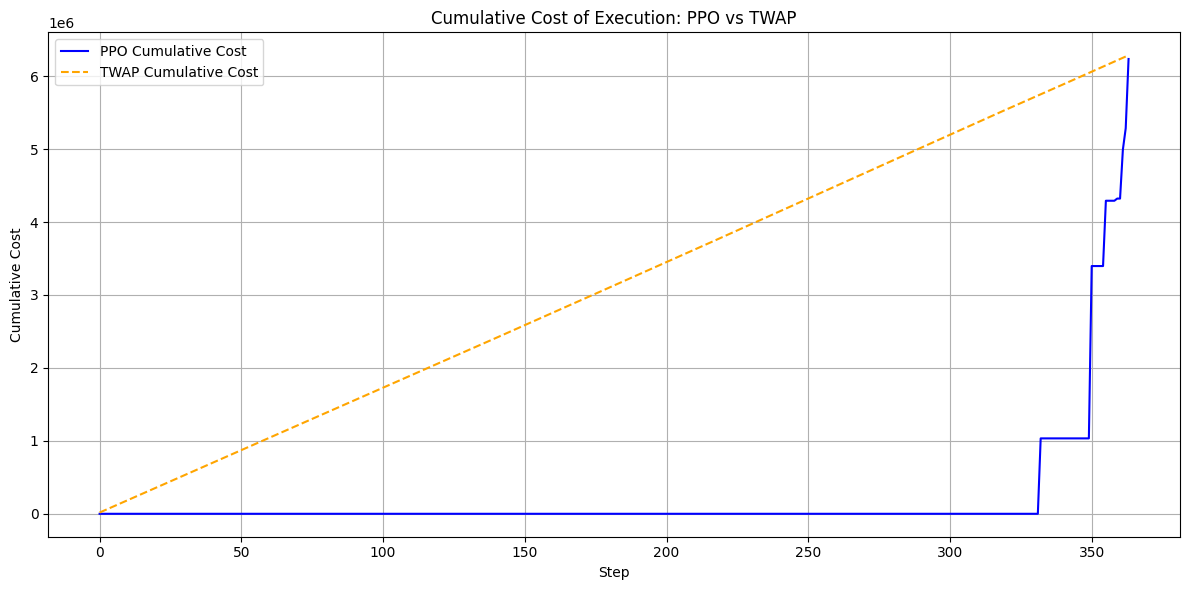

In [18]:
# Plotting Cumulative Cost Comparison: PPO vs TWAP
import matplotlib.pyplot as plt
import numpy as np

ppo_executed = np.array(env_unwrapped.executed)
ppo_qtys, ppo_prices = ppo_executed[:, 0], ppo_executed[:, 1]
ppo_cumulative_cost = np.cumsum(ppo_qtys * ppo_prices)

# Simulated TWAP execution for comparison
twap_steps = np.linspace(0, len(env_unwrapped.prices) - 1, len(ppo_qtys)).astype(int)
twap_qty = np.full_like(ppo_qtys, fill_value=env_unwrapped.total_qty / len(ppo_qtys))
twap_prices = env_unwrapped.prices[twap_steps]
twap_cumulative_cost = np.cumsum(twap_qty * twap_prices)

plt.figure(figsize=(12, 6))
plt.plot(ppo_cumulative_cost, label="PPO Cumulative Cost", color='blue')
plt.plot(twap_cumulative_cost, label="TWAP Cumulative Cost", color='orange', linestyle='--')
plt.title("Cumulative Cost of Execution: PPO vs TWAP")
plt.xlabel("Step")
plt.ylabel("Cumulative Cost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


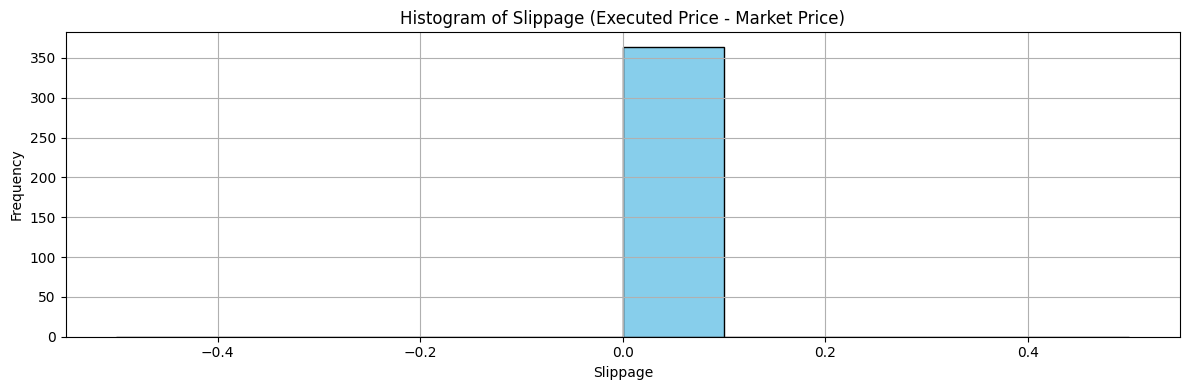

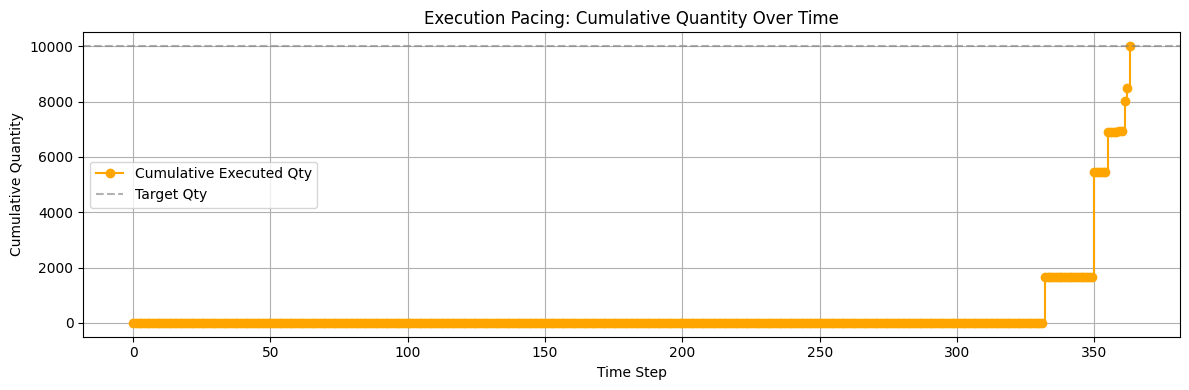

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated extraction from env.env (unwrapped)
# Replace this part in your notebook with actual: env_unwrapped = env.env
# And ensure this is done after the PPO agent has completed an episode

env_unwrapped = env.env
executed = np.array(env_unwrapped.executed)
qtys = executed[:, 0]
prices = executed[:, 1]
market_prices = env_unwrapped.prices[:len(qtys)]


# 🔹 Slippage = executed price - market price
slippages = prices - market_prices
cumulative_qty = np.cumsum(qtys)
steps = np.arange(len(qtys))

# Plot 1: Slippage Histogram
plt.figure(figsize=(12, 4))
plt.hist(slippages, bins=10, color='skyblue', edgecolor='black')
plt.title("Histogram of Slippage (Executed Price - Market Price)")
plt.xlabel("Slippage")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Execution Pacing Curve
plt.figure(figsize=(12, 4))
plt.plot(steps, cumulative_qty, drawstyle='steps-post', color='orange', marker='o', label='Cumulative Executed Qty')
plt.axhline(y=np.sum(qtys), linestyle='--', color='gray', alpha=0.6, label='Target Qty')
plt.title("Execution Pacing: Cumulative Quantity Over Time")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
